In [1]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import pandas as pd
from collections import Counter
import json
import os
import re
import tempfile
import numpy as np
from os.path import exists
from imblearn.under_sampling import RandomUnderSampler
from PIL import ImageFile
import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# custom modules
import image_faults

ImageFile.LOAD_TRUNCATED_IMAGES = True

2022-08-01 23:44:19.985182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# def dict_pics_jup():
#     '''
#     {source:target} dict used to replace source urls with image location as input
#     '''
#     target_dir = os.getcwd() + os.sep + "training_images"
#     with open('temp_pics_source_list.txt') as f:
#         temp_pics_source_list = json.load(f)
        
#     dict_pics = {}
#     for k in temp_pics_source_list:
#          patt_1 = re.search(r'[^/]+(?=/\$_|.(\.jpg|\.jpeg|\.png))', k, re.IGNORECASE)
#          patt_2 = re.search(r'(\.jpg|\.jpeg|\.png)', k, re.IGNORECASE)
#          if patt_1 and patt_2 is not None:
#              tag = patt_1.group() + patt_2.group().lower()
#              file_name = target_dir + os.sep + tag
#              dict_pics.update({k:file_name})
#     print("{source:target} dictionary created @ " + target_dir)
#     return dict_pics
def dict_pics_jup():
    '''
    {source:target} dict used to replace source urls with image location as input
    '''
    target_dir = os.getcwd() + os.sep + "training_images"
    with open('temp_pics_source_list.txt') as f:
        temp_pics_source_list = json.load(f)
        
    dict_pics = {}
    for k in temp_pics_source_list:
        try:      
             patt_1 = re.search(r'[^/]+(?=/\$_|.(\.jpg|\.jpeg|\.png))', k, re.IGNORECASE)
             patt_2 = re.search(r'(\.jpg|\.jpeg|\.png)', k, re.IGNORECASE)
             if patt_1 and patt_2 is not None:
                 tag = patt_1.group() + patt_2.group().lower()
                 file_name = target_dir + os.sep + tag
                 dict_pics.update({k:file_name})
        except TypeError:
            print(k)
    print("{source:target} dictionary created @ " + target_dir)
    return dict_pics

In [3]:
# image_faults.faulty_images() # removes faulty images
df = pd.read_csv('expanded_class.csv', index_col=[0], low_memory=False)

In [4]:
dict_pics = dict_pics_jup()

with open('women_cat_list.txt') as f:
    women_cats = json.load(f)
with open('men_cat_list.txt') as f:
    men_cats = json.load(f)
    
with open('temp_pics_source_list.txt') as f:
    tempics = json.load(f)
# list of image urls that did not get named properly which will be removed from the dataframe
drop_row_vals = []
for pic in tempics:
    try:
        dict_pics[pic]
    except KeyError:
        drop_row_vals.append(pic)

df['PrimaryCategoryID'] = df['PrimaryCategoryID'].astype(str) # pandas thinks ids are ints
ddf = df[df.PictureURL.isin(drop_row_vals)==False] # remove improperly named image files
df = ddf[ddf.PrimaryCategoryID.isin(men_cats)==False] # removes rows of womens categories

blah = pd.Series(df.PictureURL)
df = df.drop(labels=['PictureURL'], axis=1)

blah = blah.apply(lambda x: dict_pics[x])
df = pd.concat([blah, df],axis=1)
df = df.groupby('PrimaryCategoryID').filter(lambda x: len(x)>25) # removes cat outliers

nan
{source:target} dictionary created @ /home/unknown/Sync/projects/ebay ML Lister Project/training_images


In [5]:
df=df.sample(frac=1)
dict_pics['https://i.ebayimg.com/00/s/MTA2N1gxNjAw/z/-wEAAOSw2OJh7PDi/$_1.JPG?set_id=880000500F']

'/home/unknown/Sync/projects/ebay ML Lister Project/training_images/-wEAAOSw2OJh7PDi.jpg'

In [6]:
undersample = RandomUnderSampler(sampling_strategy='auto')
train, y_under = undersample.fit_resample(df, df['PrimaryCategoryID'])
#print(Counter(train['PrimaryCategoryID']))

In [7]:
train, test = train_test_split(train, test_size=0.2, random_state=42)
# stratify=train['PrimaryCategoryID']
# train['PrimaryCategoryID'].value_counts()

In [8]:
datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split=.2,
                             #samplewise_std_normalization=True,
                             #horizontal_flip= True,
                             #vertical_flip= True,
                             #width_shift_range= 0.2,
                             #height_shift_range= 0.2,
                             #rotation_range= 90,
                             preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_generator=datagen.flow_from_dataframe(
    dataframe=train[:len(train)],
    directory='./training_images',
    x_col='PictureURL',
    y_col='PrimaryCategoryID',
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(299,299),
    subset='training'
    )
validation_generator=datagen.flow_from_dataframe(
    dataframe=train[:len(train)], # is using train right?
    directory='./training_images',
    x_col='PictureURL',
    y_col='PrimaryCategoryID',
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(299,299),
    subset='validation'
    )

/home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 4 invalid image filename(s) in x_col="PictureURL". These filename(s) will be ignored.
  warnings.warn(
/home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 4 invalid image filename(s) in x_col="PictureURL". These filename(s) will be ignored.
  warnings.warn(


Found 43744 validated image filenames belonging to 7 classes.
Found 10936 validated image filenames belonging to 7 classes.


In [9]:
imgs, labels = next(train_generator)

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

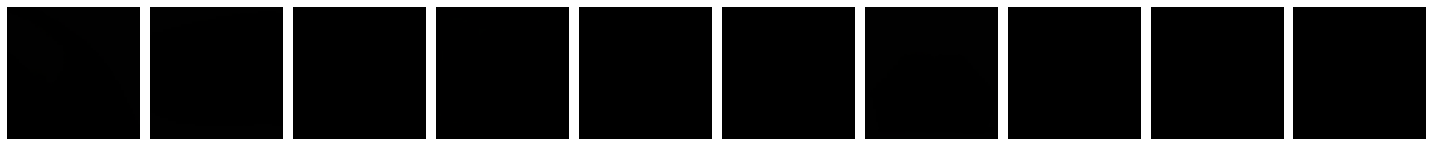

In [11]:
plotImages(imgs)
#print(labels)

In [12]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print(len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [13]:
# see https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe for train/test/val split 
# example

# may need to either create a test dataset from the original dataset or just download a new one

In [14]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg')
#base_model.summary()

2022-08-01 23:44:22.835941: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-01 23:44:22.836456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-01 23:44:22.856415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 23:44:22.856547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.725GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-08-01 23:44:22.856595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA nod

219062272/219055592 [==============================] - 368s 2us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = True
    
output = Dense(7, activation='softmax')(base_model.output)
model = tf.keras.Model(base_model.input, output)
#model = add_regularization(model)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 54,347,495
Trainable params: 54,286,951
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [16]:
#model.add(Dropout(.5))
#model.add(Dense(64, activation='softmax'))
# model.add(Dropout(.25))
#model = add_regularization(model)


In [17]:
model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])
# sparse_categorical_crossentropy

In [18]:
model.fit(x=train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          epochs=30,
          verbose=1)

2022-08-01 23:55:41.928470: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-01 23:55:41.940358: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393750000 Hz


Epoch 1/30


2022-08-01 23:55:53.471745: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38MiB (rounded to 3538944)requested by op Fill
Current allocation summary follows.
2022-08-01 23:55:53.471796: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2022-08-01 23:55:53.471803: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 479, Chunks in use: 479. 119.8KiB allocated for chunks. 119.8KiB in use in bin. 65.2KiB client-requested in use in bin.
2022-08-01 23:55:53.471807: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 525, Chunks in use: 525. 363.0KiB allocated for chunks. 363.0KiB in use in bin. 347.2KiB client-requested in use in bin.
2022-08-01 23:55:53.471811: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 190, Chunks in use: 190. 211.2KiB allocated for chunks. 211.2KiB in use in bin. 198.4KiB 

ResourceExhaustedError: in user code:

    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:604 apply_gradients
        self._create_all_weights(var_list)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:783 _create_all_weights
        self._create_slots(var_list)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/adam.py:129 _create_slots
        self.add_slot(var, 'v')
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:847 add_slot
        weight = tf_variables.Variable(
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:244 _variable_v2_call
        return previous_getter(
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3332 creator
        return next_creator(**kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:712 variable_capturing_scope
        v = UnliftedInitializerVariable(
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:227 __init__
        initial_value = initial_value()
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/keras/initializers/initializers_v2.py:139 __call__
        return super(Zeros, self).__call__(shape, dtype=_get_dtype(dtype), **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/init_ops_v2.py:154 __call__
        return array_ops.zeros(shape, dtype)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2880 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:3348 fill
        _ops.raise_from_not_ok_status(e, name)
    /home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:6862 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]
